### Signature verification using ConvNeXt and Quadruplet Loss

Dataset: https://www.kaggle.com/datasets/robinreni/signature-verification-dataset/data?select=sign_data

In [1]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Custom Image Augmentation: AddColorFilter

Applies a random color filter (red, green, or blue) to images, encouraging the model to focus on signature structure rather than ink or paper color variations, which is critical for robust signature verification.

In [2]:
class AddColorFilter:
    def __init__(self, intensity=0.3):
        self.intensity = intensity 
        
    def __call__(self, img):
        color = torch.randint(0, 3, (1,)).item()  
        filter = torch.zeros(3, *img.shape[1:])  
        
        if color == 0:    # Red
            filter[0] = self.intensity
        elif color == 1:  # Green
            filter[1] = self.intensity 
        else:             # Blue
            filter[2] = self.intensity
            
        return torch.clamp(img + filter, 0, 1)

Signature Dataset for Quadruplet Loss

Loads genuine and forged signature images, generating anchor, positive, and two negative samples for training with Quadruplet Loss


In [3]:
class SignatureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.genuine_folders = sorted([f for f in os.listdir(root_dir) if not f.endswith('_forg')])
        self.forgery_folders = [f + '_forg' for f in self.genuine_folders]
        
        self.all_anchors = []
        for folder_idx, genuine_folder in enumerate(self.genuine_folders):
            genuine_path = os.path.join(self.root_dir, genuine_folder)
            for img_name in os.listdir(genuine_path):
                self.all_anchors.append((folder_idx, img_name))
    
    def __len__(self):
        return len(self.all_anchors)
    
    def __getitem__(self, idx):
        folder_idx, anchor_img = self.all_anchors[idx]
        
        genuine_folder = os.path.join(self.root_dir, self.genuine_folders[folder_idx])
        forgery_folder = os.path.join(self.root_dir, self.forgery_folders[folder_idx])
        
        anchor = Image.open(os.path.join(genuine_folder, anchor_img))
        
        # Select a positive image (any other from the same folder)
        genuine_images = os.listdir(genuine_folder)
        # Make sure positive is different from anchor
        positive_img = random.choice([img for img in genuine_images if img != anchor_img])
        
        forgery_images = os.listdir(forgery_folder)
        negative_img1, negative_img2 = random.sample(forgery_images, 2)
        
        positive = Image.open(os.path.join(genuine_folder, positive_img))
        negative1 = Image.open(os.path.join(forgery_folder, negative_img1))
        negative2 = Image.open(os.path.join(forgery_folder, negative_img2))
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative1 = self.transform(negative1)
            negative2 = self.transform(negative2)
            
        return anchor, positive, negative1, negative2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11125986..1.0895821].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.017144758..1.096942].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005918491..1.0198225].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.101809375..1.1120569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1083844..1.1219468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027062196..1.0700052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1..1.

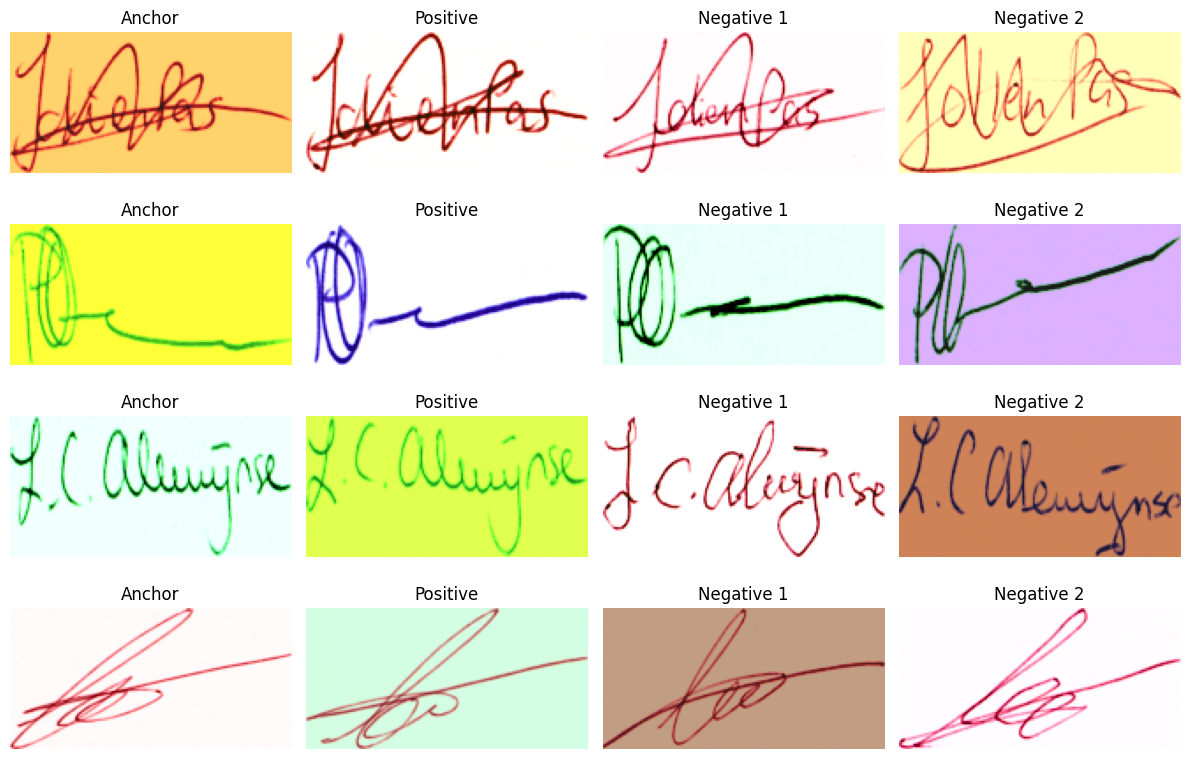

In [4]:
transform = transforms.Compose([
    transforms.Resize((80, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    AddColorFilter(intensity=0.5), 
    transforms.RandomApply([
        transforms.Lambda(lambda x: x + torch.rand(3, 1, 1) * 0.1)  
    ], p=0.7),
    transforms.RandomApply([
        transforms.Lambda(lambda x: x * torch.rand(3, 1, 1) + 0.1)  
    ], p=0.5),
])


dataset = SignatureDataset(root_dir='sign_data/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize one batch
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img.squeeze(), cmap='gray')
    if title is not None:
        plt.title(title)
    plt.axis('off')

anchors, positives, negatives1, negatives2 = next(iter(dataloader))

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(4, 4, i*4 + 1)
    imshow(anchors[i], "Anchor")
    plt.subplot(4, 4, i*4 + 2)
    imshow(positives[i], "Positive")
    plt.subplot(4, 4, i*4 + 3)
    imshow(negatives1[i], "Negative 1")
    plt.subplot(4, 4, i*4 + 4)
    imshow(negatives2[i], "Negative 2")
plt.tight_layout()
plt.show()

Quadruplet Loss

Uses anchor, positive, and two negatives to enhance embedding separation.

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QuadrupletLoss(nn.Module):
    
    def __init__(self, margin1=0.5, margin2=0.25):
        super(QuadrupletLoss, self).__init__()
        self.margin1 = margin1
        self.margin2 = margin2

    def forward(self, anchor, positive, negative1, negative2):
        cos_sim_pos = F.cosine_similarity(anchor, positive, dim=1)
        cos_sim_neg = F.cosine_similarity(anchor, negative1, dim=1)
        cos_sim_neg_b = F.cosine_similarity(negative1, negative2, dim=1)

        distance_pos = 1 - cos_sim_pos
        distance_neg = 1 - cos_sim_neg
        distance_neg_b = 1 - cos_sim_neg_b

        quadruplet_loss = (
            F.relu(self.margin1 + distance_pos - distance_neg) +
            F.relu(self.margin2 + distance_pos - distance_neg_b)
        )

        return quadruplet_loss.mean()

Load model

In [ ]:
model = timm.create_model(
    'convnext_pico_ols.d1_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

model = model.eval()

output = model(anchors)
print(output.shape)


torch.Size([4, 512])


Training Loop

In [ ]:
criterion = QuadrupletLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  

num_epochs = 20
best_loss = float('inf')
model.train()

for epoch in range(num_epochs):
    
    running_loss = 0.0
    
    for anchors, positives, negatives1, negatives2 in tqdm(dataloader, desc=f'Epoch {epoch+1}'):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives1 = negatives1.to(device)
        negatives2 = negatives2.to(device)
        
        def get_embeddings(x):
            features = model.forward_features(x)
            return model.forward_head(features, pre_logits=True)
        
        anchor_emb = get_embeddings(anchors)
        positive_emb = get_embeddings(positives)
        negative1_emb = get_embeddings(negatives1)
        negative2_emb = get_embeddings(negatives2)
        
        anchor_emb = nn.functional.normalize(anchor_emb, p=2, dim=1)
        positive_emb = nn.functional.normalize(positive_emb, p=2, dim=1)
        negative1_emb = nn.functional.normalize(negative1_emb, p=2, dim=1)
        negative2_emb = nn.functional.normalize(negative2_emb, p=2, dim=1)
        
        loss = criterion(anchor_emb, positive_emb, negative1_emb, negative2_emb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * anchors.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'best_model.pth')

print('Обучение завершено!')

Epoch 1: 100%|██████████| 222/222 [00:44<00:00,  4.95it/s]


Epoch 1, Loss: 0.3754


Epoch 2: 100%|██████████| 222/222 [00:53<00:00,  4.18it/s]


Epoch 2, Loss: 0.0954


Epoch 3: 100%|██████████| 222/222 [00:53<00:00,  4.16it/s]


Epoch 3, Loss: 0.0746


Epoch 4: 100%|██████████| 222/222 [00:53<00:00,  4.17it/s]


Epoch 4, Loss: 0.0584


Epoch 5: 100%|██████████| 222/222 [00:53<00:00,  4.17it/s]


Epoch 5, Loss: 0.0404


Epoch 6: 100%|██████████| 222/222 [00:53<00:00,  4.18it/s]


Epoch 6, Loss: 0.0385


Epoch 7: 100%|██████████| 222/222 [00:47<00:00,  4.72it/s]


Epoch 7, Loss: 0.0210


Epoch 8: 100%|██████████| 222/222 [00:54<00:00,  4.10it/s]


Epoch 8, Loss: 0.0270


Epoch 9: 100%|██████████| 222/222 [00:56<00:00,  3.95it/s]


Epoch 9, Loss: 0.0277


Epoch 10: 100%|██████████| 222/222 [00:56<00:00,  3.93it/s]


Epoch 10, Loss: 0.0123


Epoch 11: 100%|██████████| 222/222 [00:56<00:00,  3.93it/s]


Epoch 11, Loss: 0.0252


Epoch 12: 100%|██████████| 222/222 [00:52<00:00,  4.23it/s]


Epoch 12, Loss: 0.0215


Epoch 13: 100%|██████████| 222/222 [00:36<00:00,  6.07it/s]


Epoch 13, Loss: 0.0375


Epoch 14: 100%|██████████| 222/222 [00:37<00:00,  5.98it/s]


Epoch 14, Loss: 0.0306


Epoch 15: 100%|██████████| 222/222 [00:37<00:00,  5.95it/s]


Epoch 15, Loss: 0.0189


Epoch 16: 100%|██████████| 222/222 [00:37<00:00,  6.00it/s]


Epoch 16, Loss: 0.0305


Epoch 17: 100%|██████████| 222/222 [00:37<00:00,  5.98it/s]


Epoch 17, Loss: 0.0101


Epoch 18: 100%|██████████| 222/222 [00:37<00:00,  5.97it/s]


Epoch 18, Loss: 0.0102


Epoch 19: 100%|██████████| 222/222 [00:37<00:00,  5.98it/s]


Epoch 19, Loss: 0.0045


Epoch 20: 100%|██████████| 222/222 [00:37<00:00,  5.96it/s]

Epoch 20, Loss: 0.0193
Обучение завершено!


Loads image pairs with binary labels for signature verification, using genuine and forged signatures. Pairs are sampled with equal probability (50%) for genuine (same person) and forged (different sources) cases.

In [ ]:
class SignaturePairDataset(Dataset):
    def __init__(self, root_dir, transform=None, pairs_per_epoch=1000):
        self.root_dir = root_dir
        self.transform = transform
        self.pairs_per_epoch = pairs_per_epoch
        
        # Collecting paths to original and fake signatures
        self.genuine_samples = []  # (folder, img_name)
        self.forgery_samples = []   # (folder, img_name)
        
        genuine_folders = [f for f in os.listdir(root_dir) if not f.endswith('_forg')]
        for folder in genuine_folders:
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                self.genuine_samples.append((folder, img_name))
                
            forgery_folder = folder + '_forg'
            forgery_path = os.path.join(root_dir, forgery_folder)
            if os.path.exists(forgery_path):
                for img_name in os.listdir(forgery_path):
                    self.forgery_samples.append((folder, img_name))
    
    def __len__(self):
        return self.pairs_per_epoch
    
    def __getitem__(self, idx):
        # With a probability of 50% we choose a pair of the same author or different ones
        if random.random() < 0.5:
        
            folder, _ = random.choice(self.genuine_samples)
            img1, img2 = random.sample([img for (f, img) in self.genuine_samples if f == folder], 2)
            label = 1
        else:
            folder, _ = random.choice(self.genuine_samples)
            img1 = random.choice([img for (f, img) in self.genuine_samples if f == folder])
            img2 = random.choice([img for (f, img) in self.forgery_samples if f == folder])
            label = 0
        
        img1_path = os.path.join(self.root_dir, folder, img1)
        img2_path = os.path.join(self.root_dir, folder + ('_forg' if label == 0 else ''), img2)
        
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, label

Evaluates model via cosine similarity for signature authenticity.

In [ ]:
def validate(model, val_loader, device, threshold=0.7):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for img1, img2, labels in tqdm(val_loader, desc='Validation'):
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            
            emb1 = model.forward_features(img1)
            emb1 = model.forward_head(emb1, pre_logits=True)
            emb1 = torch.nn.functional.normalize(emb1, p=2, dim=1)
            
            emb2 = model.forward_features(img2)
            emb2 = model.forward_head(emb2, pre_logits=True)
            emb2 = torch.nn.functional.normalize(emb2, p=2, dim=1)
            
            # Сalculate the cosine proximity
            similarity = (emb1 * emb2).sum(dim=1)
            
            predictions = (similarity > threshold).long()
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f} | Correct: {correct}/{total}')
    print(f'Similarity Threshold: {threshold}')
    return accuracy

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((80, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # AddColorFilter(intensity=0.5),  
    # transforms.RandomApply([
    #     transforms.Lambda(lambda x: x + torch.rand(3, 1, 1) * 0.1)  
    # ], p=0.7),
    # transforms.RandomApply([
    #     transforms.Lambda(lambda x: x * torch.rand(3, 1, 1) + 0.1)  
    # ], p=0.5),
])

val_dataset = SignaturePairDataset(
    root_dir='sign_data/test',
    transform=val_transform,
    pairs_per_epoch=400  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)


In [25]:
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict']) 

model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (norm): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
       

Visualizes verification accuracy across different cosine similarity thresholds.


Evaluating with threshold = 0.0


Validation: 100%|██████████| 100/100 [00:04<00:00, 23.36it/s]


Validation Accuracy: 0.8775 | Correct: 351/400
Similarity Threshold: 0.0

Evaluating with threshold = 0.1


Validation: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Validation Accuracy: 0.9050 | Correct: 362/400
Similarity Threshold: 0.1

Evaluating with threshold = 0.2


Validation: 100%|██████████| 100/100 [00:04<00:00, 24.29it/s]


Validation Accuracy: 0.9825 | Correct: 393/400
Similarity Threshold: 0.2

Evaluating with threshold = 0.3


Validation: 100%|██████████| 100/100 [00:04<00:00, 23.44it/s]


Validation Accuracy: 0.9850 | Correct: 394/400
Similarity Threshold: 0.30000000000000004

Evaluating with threshold = 0.4


Validation: 100%|██████████| 100/100 [00:04<00:00, 24.16it/s]


Validation Accuracy: 0.9875 | Correct: 395/400
Similarity Threshold: 0.4

Evaluating with threshold = 0.5


Validation: 100%|██████████| 100/100 [00:04<00:00, 22.97it/s]


Validation Accuracy: 0.9800 | Correct: 392/400
Similarity Threshold: 0.5

Evaluating with threshold = 0.6


Validation: 100%|██████████| 100/100 [00:04<00:00, 24.18it/s]


Validation Accuracy: 0.9950 | Correct: 398/400
Similarity Threshold: 0.6000000000000001

Evaluating with threshold = 0.7


Validation: 100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


Validation Accuracy: 0.9950 | Correct: 398/400
Similarity Threshold: 0.7000000000000001

Evaluating with threshold = 0.8


Validation: 100%|██████████| 100/100 [00:04<00:00, 23.37it/s]


Validation Accuracy: 0.9925 | Correct: 397/400
Similarity Threshold: 0.8

Evaluating with threshold = 0.9


Validation: 100%|██████████| 100/100 [00:04<00:00, 23.33it/s]


Validation Accuracy: 0.9800 | Correct: 392/400
Similarity Threshold: 0.9

Evaluating with threshold = 1.0


Validation: 100%|██████████| 100/100 [00:04<00:00, 23.66it/s]


Validation Accuracy: 0.5175 | Correct: 207/400
Similarity Threshold: 1.0


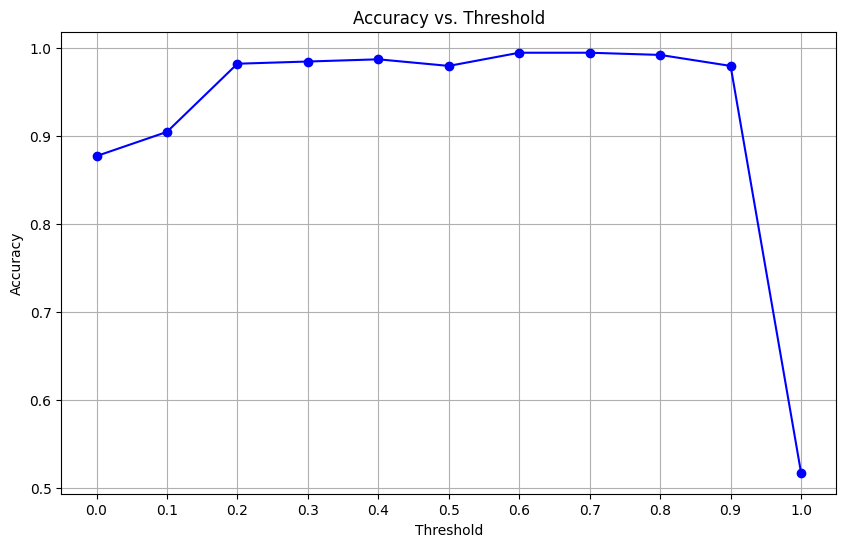


Best threshold: 0.6 with accuracy: 0.9950


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = np.arange(0, 1.1, 0.1)
accuracies = []

for threshold in thresholds:
    print(f"\nEvaluating with threshold = {threshold:.1f}")
    accuracy = validate(model, val_loader, device, threshold)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

# Find the optimal threshold (with maximum accuracy)
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
best_accuracy = accuracies[best_idx]

print(f"\nBest threshold: {best_threshold:.1f} with accuracy: {best_accuracy:.4f}")